This is the implementation of real-vs-ai-generated images detection using ViT

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from datasets import Dataset, ClassLabel, Image
from transformers import TrainingArguments, Trainer, ViTImageProcessor, ViTForImageClassification, DefaultDataCollator
import torch
from torchvision.transforms import Compose, Normalize, RandomRotation, RandomResizedCrop, RandomHorizontalFlip, RandomAdjustSharpness, Resize, ToTensor
import evaluate
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from pathlib import Path
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load image data
image_files = []
image_labels = []

for file_path in sorted((Path('dataset/cifake/').glob('*/*/*.*'))):
    label = str(file_path).split('/')[-2]
    image_labels.append(label)
    image_files.append(str(file_path))

print(len(image_files), len(image_labels))
df = pd.DataFrame({"image_path": image_files, "image_label": image_labels})
print(df.shape)

120000 120000
(120000, 2)


In [6]:
df['label'].unique()

array(['FAKE', 'REAL'], dtype=object)

In [7]:
label_data = df[['image_label']]
df = df.drop(['image_label'], axis=1)
oversampler = RandomOverSampler(random_state=83)
df, resampled_labels = oversampler.fit_resample(df, label_data)
df['image_label'] = resampled_labels
gc.collect()
print(df.shape)

(120000, 2)


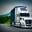

In [9]:
image_dataset = Dataset.from_pandas(df).cast_column("image_path", Image())
dataset[0]["image"]

In [12]:
label_categories = ['REAL', 'FAKE']
classification_labels = ClassLabel(num_classes=len(label_categories), names=label_categories)
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_labels(example):
    example['image_label'] = classification_labels.str2int(example['image_label'])
    return example

image_dataset = image_dataset.map(map_labels, batched=True)
image_dataset = image_dataset.cast_column('image_label', classification_labels)
split_data = image_dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="image_label")
training_dataset = split_data['train']
testing_dataset = split_data['test']

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [13]:
model_directory = "models/ai_vs_real_image_detection"
image_processor = ViTImageProcessor.from_pretrained(model_directory)
mean_image, std_image = image_processor.image_mean, image_processor.image_std
image_size = image_processor.size["height"]
print("Image Size: ", image_size)

training_transforms = Compose([Resize((image_size, image_size)), RandomRotation(90),\
                               ToTensor(), Normalize(mean=mean_image, std=std_image)])
validation_transforms = Compose([Resize((image_size, image_size)), ToTensor(), Normalize(mean=mean_image, std=std_image)])

def apply_train_transforms(examples):
    examples['processed_images'] = [training_transforms(image.convert("RGB")) for image in examples['image_path']]
    return examples

def apply_val_transforms(examples):
    examples['processed_images'] = [validation_transforms(image.convert("RGB")) for image in examples['image_path']]
    return examples


preprocessor_config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

Size:  224


In [14]:
training_dataset.set_transform(apply_train_transforms)
testing_dataset.set_transform(apply_val_transforms)

In [15]:
def batch_collator(batch):
    image_tensors = torch.stack([item["processed_images"] for item in batch])
    label_tensors = torch.tensor([item['image_label'] for item in batch])
    return {"processed_images": image_tensors, "labels": label_tensors}

In [ ]:
vit_model = ViTForImageClassification.from_pretrained(model_directory, num_labels=len(label_categories))

In [17]:
accuracy_metric = evaluate.load("accuracy")
def compute_evaluation_metrics(eval_predictions):
    prediction_scores = eval_predictions.predictions
    true_labels = eval_predictions.label_ids
    predicted_labels = prediction_scores.argmax(axis=1)
    accuracy_result = accuracy_metric.compute(predictions=predicted_labels, references=true_labels)['accuracy']
    return {"accuracy": accuracy_result}

In [18]:
training_args = TrainingArguments(
    output_dir=model_directory,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.02,
    warmup_steps=50,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)



In [19]:
model_trainer = Trainer(
    model=vit_model,
    args=training_args,
    train_dataset=training_dataset,
    eval_dataset=testing_dataset,
    data_collator=batch_collator,
    compute_metrics=compute_evaluation_metrics,
    tokenizer=image_processor,
)


In [21]:
model_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.036500,0.044724,0.983812
2,0.034100,0.043966,0.984271


TrainOutput(global_step=2250, training_loss=0.03648328993055556, metrics={'train_runtime': 4357.2495, 'train_samples_per_second': 33.048, 'train_steps_per_second': 0.516, 'total_flos': 1.1158846504501248e+19, 'train_loss': 0.03648328993055556, 'epoch': 2.0})

In [22]:
model_trainer.evaluate()

{'eval_loss': 0.0439663790166378,
 'eval_accuracy': 0.9842708333333333,
 'eval_runtime': 384.6814,
 'eval_samples_per_second': 124.779,
 'eval_steps_per_second': 3.899,
 'epoch': 2.0}

In [23]:
test_outputs = model_trainer.predict(testing_dataset)
print(test_outputs.metrics)

{'test_loss': 0.0439663790166378, 'test_accuracy': 0.9842708333333333, 'test_runtime': 385.5472, 'test_samples_per_second': 124.498, 'test_steps_per_second': 3.891}


Accuracy: 0.9843
F1 Score: 0.9843


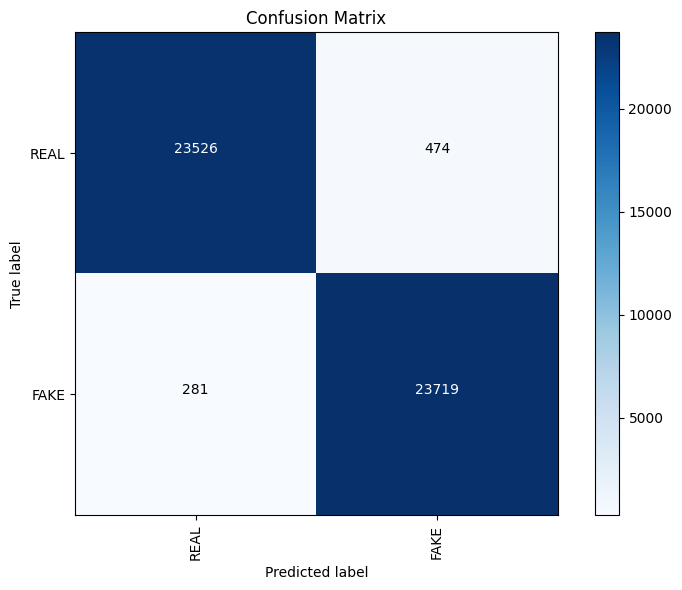


Classification report:

              precision    recall  f1-score   support

        REAL     0.9882    0.9802    0.9842     24000
        FAKE     0.9804    0.9883    0.9843     24000

    accuracy                         0.9843     48000
   macro avg     0.9843    0.9843    0.9843     48000
weighted avg     0.9843    0.9843    0.9843     48000



In [24]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Assuming y_true and y_pred have been defined elsewhere in your script, like from the output of a model
y_true = test_outputs.label_ids
y_pred = test_outputs.predictions.argmax(1)

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(label_categories) <= 150:  # Using 'label_categories' which should have been defined earlier
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, label_categories, figsize=(8, 6))

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=label_categories, digits=4))